## Steps to fine tune model
- Select and load model
- Select and preprocess dataset (train/eval split, tokenize)
- Define quantization or adaptation before fine-tuning for efficiency
- Tune and evaluate model



### Load model

In [1]:
!pip install -q accelerate transformers peft


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install -q datasets scipy ipywidgets matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
!pip install -q bitsandbytes


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
!pip install -q sentencepiece


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
import torch
print(torch.cuda.is_available())

True


In [6]:
!nvidia-smi

Thu Feb 29 10:23:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L40                     On  | 00000000:00:06.0 Off |                    0 |
| N/A   32C    P8              35W / 300W |      7MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
import accelerate

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
    # bnb_4bit_compute_dtype=torch.float16
)

hf_modelname = "mistralai/Mistral-7B-Instruct-v0.2"

model = AutoModelForCausalLM.from_pretrained(hf_modelname, device_map="auto",
                                             quantization_config=bnb_config,
                                            #  torch_dtype=torch.float16, load_in_8bit=True,
                                             token=access_token)
# tokenizer = AutoTokenizer.from_pretrai\ned("microsoft/phi-2")#, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(
    hf_modelname,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False,
    token=access_token
)
tokenizer.pad_token = tokenizer.eos_token


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

In [9]:
import torch
print(torch.cuda.is_available(), model.device)
model.num_parameters()

True cuda:0


7241732096

In [10]:
import numpy as np
import pandas as pd

def count_trainable_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params
count_trainable_parameters(model)

262410240

In [8]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [20]:
!nvidia-smi

Thu Feb 29 10:38:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L40                     On  | 00000000:00:06.0 Off |                    0 |
| N/A   42C    P0             105W / 300W |   5568MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
inputs = tokenizer("""[INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
  The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
  Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
  and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
  [/INST]""",
                   return_tensors="pt", return_attention_mask=False).to("cuda")

outputs = model.generate(**inputs, max_length=500)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


<s> [INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
  The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
  Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
  and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
  [/INST] </s>1. **Welcome Back Email (Month 1)**
   Reason: A warm welcome email is a great way to re-introduce your service to dormant users and remind them of the benefits they received when they were active.
   Content: Personalized greeting, a brief summary of new features or improvements since their last visit, and a call-to-action (CTA) to explore the platform.
   Strategy: Monitor open and click-through rates (CTR) to gauge interest. If the response is low, consider offering a special promotion or

In [21]:
# with open('finetune-emails.txt', 'r') as file:
#     text = ''.join([row for row in file.readlines() if row != '\n'])
# with open('sadyr_preprocessed.txt', 'w') as file:
#     file.write(text)

from datasets import load_dataset
dataset = load_dataset(path='text', data_files='finetune-emails.txt', split='train')
dataset = dataset.train_test_split(train_size=0.9)

Generating train split: 0 examples [00:00, ? examples/s]

In [22]:
dataset['train'], dataset['test']

(Dataset({
     features: ['text'],
     num_rows: 30132
 }),
 Dataset({
     features: ['text'],
     num_rows: 3349
 }))

In [23]:
generate_and_tokenize_prompt = lambda prompt: tokenizer(prompt['text'])

tokenized_train_dataset = dataset['train'].map(generate_and_tokenize_prompt)
tokenized_val_dataset = dataset['test'].map(generate_and_tokenize_prompt)

Map:   0%|          | 0/30132 [00:00<?, ? examples/s]

Map:   0%|          | 0/3349 [00:00<?, ? examples/s]

33481


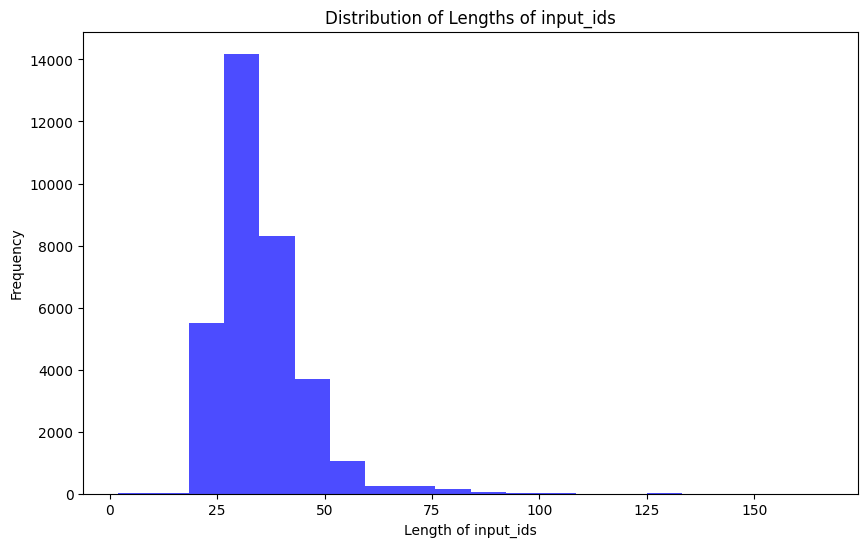

In [15]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)


In [24]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)


In [28]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

In [26]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        # "dense",
        "gate_proj",
        "up_proj",
        "down_proj",
        # "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
# print_trainable_parameters(model)


In [27]:
f'trainable params: {100 * count_trainable_parameters(model) / model.num_parameters()}'

'trainable params: 1.0317767305015078'

In [12]:
# from accelerate import FullyShardedDataParallelPlugin, Accelerator
# from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

# fsdp_plugin = FullyShardedDataParallelPlugin(
#     state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
#     optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
# )

# accelerator = Accelerator(fsdp_plugin=fsdp_plugin)
# model = accelerator.prepare_model(model)


In [31]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True


import transformers
from datetime import datetime

project = "emails"
base_model_name = "mistral-7b-it"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        # per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        # max_steps=500,
        num_train_epochs=2,
        learning_rate=1e-5, # Want a small lr for finetuning
        bf16=True,
        # fp16=True,
        optim="paged_adamw_8bit",
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        # optim="paged_adamw_32bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=100,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        # report_to="wandb",           # Comment this out if you don't want to use weights & baises
        # run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss
100,1.688500,1.578887
200,1.433700,1.389078
300,1.329900,1.320793
400,1.295300,1.277465
500,1.220100,1.251784
600,1.217600,1.234480
700,1.191600,1.219666
800,1.195000,1.211399
900,1.192000,1.206270


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=942, training_loss=1.363041420144893, metrics={'train_runtime': 5108.2986, 'train_samples_per_second': 11.797, 'train_steps_per_second': 0.184, 'total_flos': 2.401910503810007e+17, 'train_loss': 1.363041420144893, 'epoch': 2.0})

In [32]:
!nvidia-smi

Thu Feb 29 12:07:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L40                     On  | 00000000:00:06.0 Off |                    0 |
| N/A   56C    P0              89W / 300W |  32742MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [33]:
import accelerate

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
    # bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(hf_modelname, device_map="auto",
                                             quantization_config=bnb_config,
                                            #  torch_dtype=torch.float16, load_in_8bit=True,
                                             token=access_token)
# tokenizer = AutoTokenizer.from_pretrai\ned("microsoft/phi-2")#, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(
    hf_modelname,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False,
    token=access_token
)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [36]:
from peft import PeftModel
for i in range(100,1000,100):
    checkpoint_name = f"{run_name}/checkpoint-{i}"
    ft_model = PeftModel.from_pretrained(model, checkpoint_name)
    
    inputs = tokenizer("""[INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
          The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
          Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
          and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
          [/INST]""",
        return_tensors="pt", return_attention_mask=False).to("cuda")
    
    outputs = ft_model.generate(**inputs, max_length=500)
    text = tokenizer.batch_decode(outputs)[0]
    print(checkpoint_name) 
    print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


mistral-7b-it-emails/checkpoint-100
<s> [INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
          The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
          Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
          and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
          [/INST]</s>1. Welcome Back Email (Month 0):
Reason: A simple and friendly reminder that they have an account with your service and that you've missed them.
Content: "Hi [Name], we've missed you! Welcome back to [Your Service]. We've got some great new listings for houses and apartments in the Netherlands that we think you'll love."
Adjustment: If successful, follow up with a personalized email in the next month. If not, try the next con

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


mistral-7b-it-emails/checkpoint-200
<s> [INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
          The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
          Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
          and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
          [/INST]</s>1. Welcome Back Email (Month 1):
Reason: A simple and friendly reminder that they have an account with your service and that they might find something interesting.
Content: "Hi [Name], welcome back to [Your Service]! We've missed you and hope you're doing well. We'd love to help you find your dream home in the Netherlands. Check out the latest listings that might catch your eye."
Adjustment: If the user clicks through and sta

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


mistral-7b-it-emails/checkpoint-300
<s> [INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
          The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
          Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
          and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
          [/INST]</s>1. Welcome Back Email (Month 1):
Reason: A simple and friendly reminder that they have an account with your service and that they might find something interesting on the platform.
Content Strategy: Include a call-to-action (CTA) button to encourage users to log back in and explore new listings.
Adjustment: Monitor open and click-through rates (CTR) to determine if users are re-engaging with the platform. If not, consider offe

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


mistral-7b-it-emails/checkpoint-400
<s> [INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
          The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
          Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
          and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
          [/INST]</s>1. Welcome Back Email (Month 1):
Reason: A simple and friendly reminder that they have an account with your service and that you're glad they're back.
Content Strategy: Include a brief update on new listings, recent sales, and any new features or improvements to the platform.
Adjustment: If successful, continue sending monthly updates and offers. If not, consider sending more personalized and targeted emails.

2. Personalized

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


mistral-7b-it-emails/checkpoint-500
<s> [INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
          The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
          Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
          and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
          [/INST]</s>1. Welcome Back Email (Month 1):
Reason: A simple and friendly reminder that they have an account with your service and that you're glad they're back.
Content Strategy: Include a brief update on new listings, features, or promotions since their last visit.
Adjustment: Monitor open and click-through rates to gauge interest and adjust the content accordingly.

2. Personalized Property Recommendations (Month 2):
Reason: Show use

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


mistral-7b-it-emails/checkpoint-600
<s> [INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
          The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
          Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
          and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
          [/INST]</s>1. Welcome Back Email (Month 1):
Reason: A simple and friendly reminder that they have an account with your service and that they might find something interesting.
Content Strategy: Include a personalized greeting, a brief update on new listings or features, and a clear call-to-action to log back in.

2. Personalized Listings Email (Month 2):
Reason: Show users that your service still adds value to their home buying journey b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


mistral-7b-it-emails/checkpoint-700
<s> [INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
          The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
          Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
          and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
          [/INST]</s>1. Welcome Back Email (Month 1):
Reason: A simple and friendly reminder that they have an account with your service and that they haven't used it in a while.
Content Strategy: Include a call-to-action (CTA) button to encourage them to log back in and explore new listings.
Adjustment: If successful, follow up with a newsletter showcasing popular properties or neighborhoods.

2. Personalized Property Recommendations (Month 2):


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


mistral-7b-it-emails/checkpoint-800
<s> [INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
          The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
          Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
          and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
          [/INST]</s>1. Welcome Back Email (Month 1):
Reason: A simple and friendly reminder that they have an account with your service and that they haven't used it in a while.
Content Strategy: Include a call-to-action (CTA) button to encourage them to log back in and explore new listings.
Adjustment: If successful, send a follow-up email with personalized recommendations based on their previous searches.

2. New Listings Email (Month 2):
Reas

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


mistral-7b-it-emails/checkpoint-900
<s> [INST]Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
          The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
          Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
          and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
          [/INST]</s>1. Welcome Back Email (Month 1):
Reason: A simple and friendly reminder that they have an account with your service and that they haven't used it in a while.
Content Strategy: Include a call-to-action (CTA) button to encourage them to log back in and explore new listings.
Adjustment: If successful, send a follow-up email with personalized recommendations based on their previous searches.

2. New Listings Email (Month 2):
Reas

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(model, f"{run_name}/checkpoint-{i}")


In [3]:
inputs = tokenizer("""
  Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
  The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
  Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
  and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
""",
                   return_tensors="pt", return_attention_mask=False).to("cuda")

outputs = ft_model.generate(**inputs, max_length=500)
text = tokenizer.batch_decode(outputs)[0]
print(text)

<bos>
  Give me an email-only content calendar for activating users that haven't used my service in more than 3 months.
  The service is an online marketplace for prospective home buyers to find houses and apartments in the Netherlands.
  Instructions: for each content idea provided, give me why this is something that makes sense for activating dormant users,
  and how to adjust the content strategy depending on whether it has been successful at activating the user after each month.
<eos><bos>1. **Welcome Email:**
 - Subject: Welcome to HomeFinds! Get a 100€ discount on your first search. 🏡 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 💰 
